In [1]:
import numpy as np
from scipy.optimize import dual_annealing
import pulp
import pandas as pd
import os
import random
from wmape import WMAPE
from order_generator import OrderGenerator
from order_merger import OrderMerger
import math
import matplotlib.pyplot as plt

In [2]:
random.seed(42)

In [3]:
def objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day):
    # Apply the current allocation to the orders dataframe
    orders_df['site'] = current_allocation

    # Aggregate the orders for the initial and target lead days
    aggregated_initial_df = OrderMerger.aggregate_items(orders_df, initial_day)
    aggregated_target_df = OrderMerger.aggregate_items(target_orders_df, target_day)

    # Merge the aggregated dataframes
    merged_df = OrderMerger.merge_allocation(aggregated_target_df, aggregated_initial_df, target_day, initial_day)

    # Calculate WMAPE
    _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{target_day}', f'lead_{initial_day}')
    return wmape_site

In [4]:
def generate_multi_step_neighbor(current_allocation, orders_df, eligibility_dict, steps=3):
    new_allocation = current_allocation.copy()

    for _ in range(steps):
        max_attempts = 100

        unique_order_ids = orders_df['order_id'].unique()

        for _ in range(max_attempts):
            order_indices = random.sample(range(len(unique_order_ids)), 2)

            order_id1 = unique_order_ids[order_indices[0]]
            order_id2 = unique_order_ids[order_indices[1]]

            items1 = orders_df[orders_df['order_id'] == order_id1]['item_id'].tolist()
            items2 = orders_df[orders_df['order_id'] == order_id2]['item_id'].tolist()

            site1 = new_allocation[orders_df[orders_df['order_id'] == order_id1].index[0]]
            site2 = new_allocation[orders_df[orders_df['order_id'] == order_id2].index[0]]

            if all(item in eligibility_dict[site2] for item in items1) and all(item in eligibility_dict[site1] for item in items2):
                new_allocation[orders_df[orders_df['order_id'] == order_id1].index] = site2
                new_allocation[orders_df[orders_df['order_id'] == order_id2].index] = site1
                break

    return new_allocation

In [5]:
def adaptive_cooling_schedule(temp, alpha, improvement_rate):
    if improvement_rate > 0.01:
        alpha = min(alpha * 1.01, 0.99)  # Slightly increase alpha but cap it to 0.99
    elif improvement_rate < 0.001:
        alpha = max(alpha * 0.99, 0.90)  # Slightly decrease alpha but ensure it doesn't drop too low
    return temp * alpha


def acceptance_probability(current_energy, new_energy, temperature):
    if new_energy < current_energy:
        return 1.0
    else:
        return math.exp((current_energy - new_energy) / temperature)


In [6]:
def simulated_annealing(orders_df, target_orders_df, eligibility_dict, initial_day, target_day, initial_temp, final_temp, alpha):
    current_allocation = orders_df['site'].values
    best_allocation = current_allocation.copy()
    current_energy = objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day)
    best_energy = current_energy

    temp = initial_temp
    step = 0

    while temp > final_temp:
        new_allocation = generate_multi_step_neighbor(current_allocation, orders_df, eligibility_dict)
        new_energy = objective_function(new_allocation, orders_df, target_orders_df, initial_day, target_day)

        if acceptance_probability(current_energy, new_energy, temp) > random.random():
            current_allocation = new_allocation
            current_energy = new_energy

            if current_energy < best_energy:
                best_allocation = current_allocation
                best_energy = current_energy

        improvement_rate = (current_energy - best_energy) / current_energy
        temp = adaptive_cooling_schedule(temp, alpha, improvement_rate)
        step += 1

        if step % 100 == 0:
            print(f'Step {step}: Best Energy {best_energy}, Temperature: {temp}')

    print(f'Final Step: {step}, Final Temperature: {temp}')
    return best_allocation, best_energy

In [44]:
allocation_dir = 'allocations'
merged_dir = 'merged'
sa_allocation_dir = 'sa_allocations'
sa_merged_dir = 'sa_merged'

# Create the merged directory if it doesn't exist
os.makedirs(sa_allocation_dir, exist_ok=True)
os.makedirs(sa_merged_dir, exist_ok=True)

In [49]:
def perform_simulated_annealing(lead_days, initial_temp, final_temp, alpha, max_iter, eligibility_dict):
    # Load the initial allocation dataframe for the first lead day
    previous_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_days[0]}.csv')
    
    # Ensure the first lead day stays unmodified
    previous_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{lead_days[0]}.csv', index=False)
    
    for i in range(1, len(lead_days)):
        current_day = lead_days[i]
        previous_day = lead_days[i-1]
        
        current_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{current_day}.csv')

        best_allocation, best_energy = simulated_annealing(current_df.copy(), previous_df.copy(), eligibility_dict, current_day, previous_day, initial_temp, final_temp, alpha)
        # Update the allocation for the current day with the best found allocation
        current_df['site'] = best_allocation
        
        # Save the updated dataframe for the current lead day
        current_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{current_day}.csv', index=False)
        
        # Set the current dataframe as the previous dataframe for the next iteration
        previous_df = current_df.copy()

In [50]:
def calculate_wmape_for_all_days(lead_days):
    wmape_site_values = []
    wmape_global_values = []

    final_day = lead_days[-1]
    final_day_df = pd.read_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{final_day}.csv')
    aggregated_final_day = OrderMerger.aggregate_items(final_day_df, final_day)
    
    for day in lead_days[:-1]:
        current_df = pd.read_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{day}.csv')
        aggregated_current_day = OrderMerger.aggregate_items(current_df, day)
        
        merged_df = OrderMerger.merge_allocation(aggregated_current_day, aggregated_final_day, day, final_day)
        
        site_df, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{day}', f'lead_{final_day}')
        global_df, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{day}', f'lead_{final_day}')
        
        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)
        
        # Save the merged dataframe
        merged_df.to_csv(f'{sa_merged_dir}/sa_merged_lead_day_{day}_to_{final_day}.csv', index=False)
    
    # Add 0 for lead day 0
    wmape_site_values.append(0)
    wmape_global_values.append(0)
    
    return wmape_site_values, wmape_global_values

In [51]:
def plot_wmape(lead_days, wmape_site_values, wmape_global_values):
    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(lead_days, wmape_site_values, linestyle='-', color='b', label='WMAPE Site')
    ax.plot(lead_days, wmape_global_values, linestyle='-', color='r', label='WMAPE Global')

    # Add labels and title
    ax.set_xlabel('Lead Day')
    ax.set_ylabel('Error')
    ax.set_title('WMAPE Values for Different Lead Days - Simulated Annealing')
    ax.set_xticks(lead_days)
    ax.legend()

    # Invert x-axis to have 0 at the end
    ax.invert_xaxis()

    plt.show()


In [86]:

lead_days = list(range(18, -1, -1))  # Define the lead days from 18 to 0
initial_temp = 100
final_temp = 0.1
alpha = 0.95
max_iter = 10000

eligibility_dict = OrderGenerator.load_eligibility_dict('eligibility_dict.json')

# Perform simulated annealing for consecutive lead days
perform_simulated_annealing(lead_days, initial_temp, final_temp, alpha, max_iter, eligibility_dict)

Step 100: Best Energy 0.39260077305356156, Temperature: 1.1646996530615346
Final Step: 160, Final Temperature: 0.09747936476493886
Step 100: Best Energy 0.3687137330754352, Temperature: 0.8387038010688775
Final Step: 138, Final Temperature: 0.09768086666736406
Step 100: Best Energy 0.3194657841862664, Temperature: 0.9826596849263198
Final Step: 144, Final Temperature: 0.09683958934900898
Step 100: Best Energy 0.5420588674734798, Temperature: 0.5039568440690955
Final Step: 139, Final Temperature: 0.09754014795617952
Step 100: Best Energy 0.39477630592351914, Temperature: 0.5129565733545005
Final Step: 140, Final Temperature: 0.09814761764960628
Step 100: Best Energy 0.5060679611650486, Temperature: 0.4081903458820448
Final Step: 126, Final Temperature: 0.09728108650755728
Step 100: Best Energy 0.472142064372919, Temperature: 0.35819560989671473
Final Step: 125, Final Temperature: 0.0993597273233646
Step 100: Best Energy 0.4556386958845537, Temperature: 0.4940763109436082
Final Step: 132

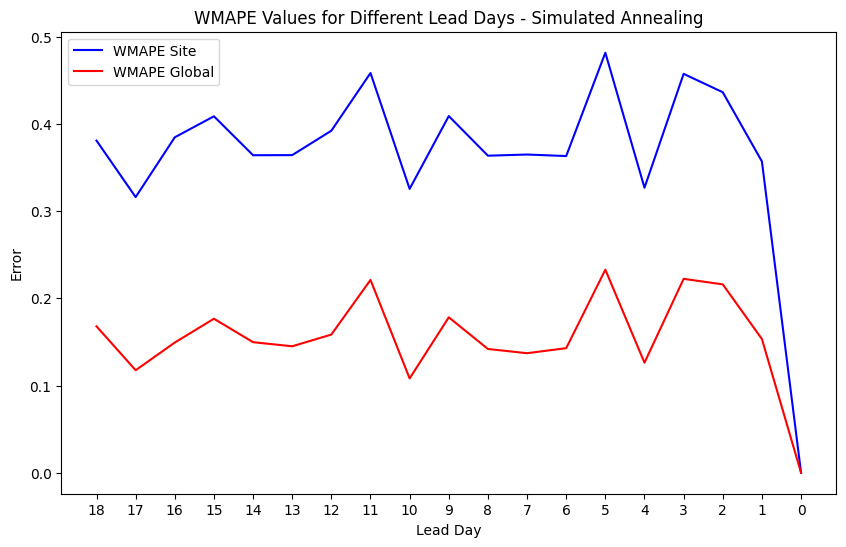

In [53]:
# Calculate WMAPE for all days
wmape_site_values, wmape_global_values = calculate_wmape_for_all_days(lead_days)
# Plot the WMAPE values
plot_wmape(lead_days, wmape_site_values, wmape_global_values)

In [76]:
def calculate_and_plot_wmape(pairs):
    wmape_site_values = []
    wmape_global_values = []
    wmape_site_sa_values = []
    wmape_global_sa_values = []

    sa_allocation_dir = 'sa_allocations'  # Path to the directory containing the simulated annealing allocation files
    merged_allocation_dir = 'sa_merged_consec'  # Path to the directory to save the merged allocation files

    if not os.path.exists(merged_allocation_dir):
        os.makedirs(merged_allocation_dir)

    for previous_day, current_day in pairs:
        merged_df = pd.read_csv(f'merged_consec/merged_allocation_lead_day_{previous_day}_to_{current_day}.csv')
        
        _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{previous_day}', f'lead_{current_day}')
        _, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{previous_day}', f'lead_{current_day}')

        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)

        # With simulated annealing
        current_df_sa = pd.read_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{current_day}.csv')
        previous_df_sa = pd.read_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{previous_day}.csv')

        aggregated_current_day_sa = OrderMerger.aggregate_items(current_df_sa, current_day)
        aggregated_previous_day_sa = OrderMerger.aggregate_items(previous_df_sa, previous_day)

        merged_df_sa = OrderMerger.merge_allocation(aggregated_previous_day_sa, aggregated_current_day_sa, previous_day, current_day)

        _, wmape_site_sa = WMAPE.calculate_wmape_site(merged_df_sa, f'lead_{previous_day}', f'lead_{current_day}')
        _, wmape_global_sa = WMAPE.calculate_wmape_global(merged_df_sa, f'lead_{previous_day}', f'lead_{current_day}')

        wmape_site_sa_values.append(wmape_site_sa)
        wmape_global_sa_values.append(wmape_global_sa)

        # Save the merged dataframes with simulated annealing
        merged_df_sa.to_csv(f'{merged_allocation_dir}/merged_allocation_sa_lead_day_{previous_day}_to_{current_day}.csv', index=False)

    lead_days_consecutive = [previous_day for _, previous_day in pairs]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(lead_days_consecutive, wmape_site_values, linestyle='-', color='b', label='WMAPE Site Without SA')
    ax.plot(lead_days_consecutive, wmape_global_values, linestyle='-', color='r', label='WMAPE Global')
    ax.plot(lead_days_consecutive, wmape_site_sa_values, linestyle='--', color='b', label='WMAPE Site With SA')

    ax.set_xlabel('Lead Day')
    ax.set_ylabel('Error')
    ax.set_title('WMAPE Values for Consecutive Lead Days')
    ax.set_xticks(lead_days_consecutive)
    ax.legend()

    ax.invert_xaxis()

    plt.show()

In [ ]:
lead_days = list(range(18, -1, -1))
eligibility_dict = OrderGenerator.load_eligibility_dict('eligibility_dict.json')
pairs = [(18, 17), (17, 16), (16, 15), (15, 14), (14, 13), (13, 12), (12, 11), (11, 10), (10, 9), (9, 8), (8, 7), (7, 6), (6, 5), (5, 4), (4, 3), (3, 2), (2, 1), (1, 0)]

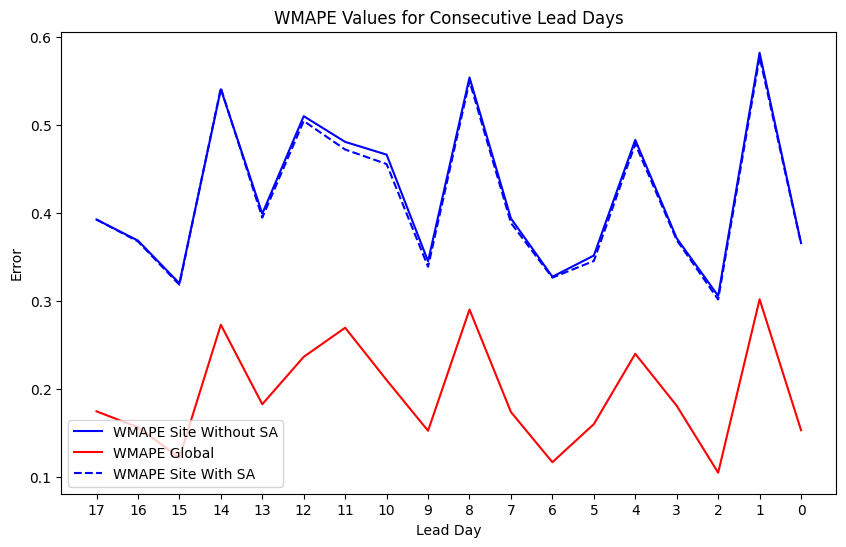

In [87]:
# Calculate and plot WMAPE
calculate_and_plot_wmape(pairs)

In [88]:
def calculate_area_under_curve(lead_days, merged_consec_dir):
    wmape_values = []
    
    # Reverse the lead_days array to ensure ascending order
    lead_days = sorted(lead_days)

    # Calculate WMAPE for each consecutive lead day pair
    for i in range(1, len(lead_days)):
        soft_day = lead_days[i]
        hard_day = lead_days[i - 1]
        
        merged_df = pd.read_csv(f"{merged_consec_dir}/merged_allocation_sa_lead_day_{soft_day}_to_{hard_day}.csv")
        _, wmape_site_value = WMAPE.calculate_wmape_site(merged_df, soft_col=f'lead_{soft_day}', hard_col=f'lead_{hard_day}')
        wmape_values.append(wmape_site_value)
    
    # Calculate area under the curve using the trapezoidal rule
    x = np.array(lead_days[1:])  # Lead days after the first one
    y = np.array(wmape_values)
    auc = np.trapz(y, x)
    
    return auc

lead_days = list(range(18, -1, -1))
merged_consec_dir = 'sa_merged_consec'  # Directory containing merged consecutive files

auc_value = calculate_area_under_curve(lead_days, merged_consec_dir)
print(f"Area under the WMAPE site curve after simulated annealing: {auc_value}")

Area under the WMAPE site curve after simulated annealing: 7.110736700754477


In [7]:
def calculate_area_under_curve(lead_days, merged_consec_dir):
    wmape_values = []
    
    # Reverse the lead_days array to ensure ascending order
    lead_days = sorted(lead_days)

    # Calculate WMAPE for each consecutive lead day pair
    for i in range(1, len(lead_days)):
        soft_day = lead_days[i]
        hard_day = lead_days[i - 1]
        
        merged_df = pd.read_csv(f"merged_consec/merged_allocation_lead_day_{soft_day}_to_{hard_day}.csv")
        _, wmape_site_value = WMAPE.calculate_wmape_site(merged_df, soft_col=f'lead_{soft_day}', hard_col=f'lead_{hard_day}')
        wmape_values.append(wmape_site_value)
    
    # Calculate area under the curve using the trapezoidal rule
    x = np.array(lead_days[1:])  # Lead days after the first one
    y = np.array(wmape_values)
    auc = np.trapz(y, x)
    
    return auc

lead_days = list(range(18, -1, -1))
merged_consec_dir = 'merged_consec'  # Directory containing merged consecutive files

auc_value = calculate_area_under_curve(lead_days, merged_consec_dir)
print(f"Area under the WMAPE site curve: {auc_value}")

Area under the WMAPE site curve: 7.180008616088909


Step 100: Best Energy 0.48278181329028785, Temperature: 3522.355644853137
Step 200: Best Energy 0.48278181329028785, Temperature: 1753.8104229270507
Step 300: Best Energy 0.48170567662093083, Temperature: 1256.7026944537838
Step 400: Best Energy 0.48170567662093083, Temperature: 464.1755916219787
Step 500: Best Energy 0.48170567662093083, Temperature: 282.03188012148973
Step 600: Best Energy 0.48170567662093083, Temperature: 123.71533483638032
Step 700: Best Energy 0.48170567662093083, Temperature: 46.53008817563892
Step 800: Best Energy 0.48170567662093083, Temperature: 17.031517114578918
Step 900: Best Energy 0.48170567662093083, Temperature: 6.347948318335591
Step 1000: Best Energy 0.48170567662093083, Temperature: 2.9936502746168747
Step 1100: Best Energy 0.48170567662093083, Temperature: 1.6615523549941278
Step 1200: Best Energy 0.48170567662093083, Temperature: 0.619290014316044
Step 1300: Best Energy 0.48170567662093083, Temperature: 0.22874090272057163
Step 1400: Best Energy 0.

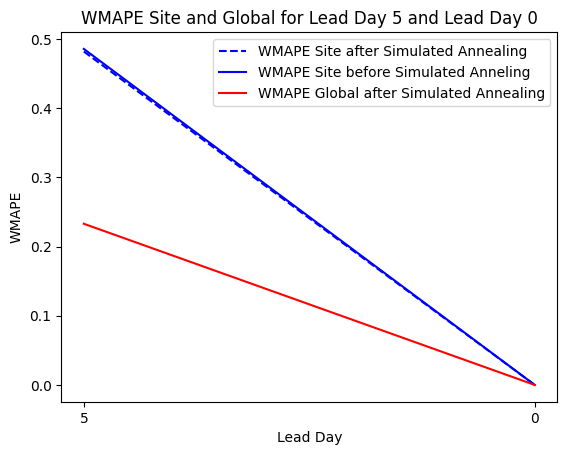

In [62]:
def perform_simulated_annealing_and_plot(orders_df, target_orders_df, eligibility_dict, initial_temp, final_temp, alpha):
    # order before applying simulated annealing
    orders_df_prev = orders_df.copy()

    # Apply simulated annealing between lead day 5 and lead day 0
    best_allocation, best_energy = simulated_annealing(orders_df.copy(), target_orders_df.copy(), eligibility_dict, 0, 5, initial_temp, final_temp, alpha)

    # Update orders_df with the best allocation found
    orders_df['site'] = best_allocation

    # Aggregate and merge the results with the target lead day 0
    aggregated_current_day_prev = OrderMerger.aggregate_items(orders_df_prev, 0)
    aggregated_current_day_sa = OrderMerger.aggregate_items(orders_df, 0)
    aggregated_previous_day_sa = OrderMerger.aggregate_items(target_orders_df, 5)
    merged_prev = OrderMerger.merge_allocation(aggregated_previous_day_sa, aggregated_current_day_prev, 5, 0)
    merged_df = OrderMerger.merge_allocation(aggregated_previous_day_sa, aggregated_current_day_sa, 5, 0)

    # Calculate WMAPE for results before simulated annealing
    _, wmape_site_value_prev = WMAPE.calculate_wmape_site(merged_prev, 'lead_5', 'lead_0')

    # Calculate WMAPE for the simulated annealing results
    _, wmape_site_value = WMAPE.calculate_wmape_site(merged_df, 'lead_5', 'lead_0')
    _, wmape_global_value = WMAPE.calculate_wmape_global(merged_df, 'lead_5', 'lead_0')

    # Plot the results
    lead_days = [5, 0]
    wmape_site_values_prev = [wmape_site_value_prev, 0]
    wmape_site_values = [wmape_site_value, 0] 
    wmape_global_values = [wmape_global_value, 0]

    plt.plot(lead_days, wmape_site_values, linestyle='--', color='b', label="WMAPE Site after Simulated Annealing")
    plt.plot(lead_days, wmape_site_values_prev, linestyle = '-', color='b', label="WMAPE Site before Simulated Anneling")
    plt.plot(lead_days, wmape_global_values, linestyle='-', color='r', label="WMAPE Global after Simulated Annealing")
    plt.xlabel('Lead Day')
    plt.ylabel('WMAPE')
    plt.title('WMAPE Site and Global for Lead Day 5 and Lead Day 0')
    plt.xticks([5, 0])
    plt.gca().invert_xaxis()  # Invert x-axis to have 0 at the end
    plt.legend()
    plt.show()

# Example usage
initial_temp = 5000
final_temp = 0.01
alpha = 0.999
max_iter = 1000
eligibility_dict = OrderGenerator.load_eligibility_dict('eligibility_dict.json')

# Load the orders and target orders DataFrames
orders_df = pd.read_csv('allocations/allocation_lead_day_0.csv')
target_orders_df = pd.read_csv('allocations/allocation_lead_day_5.csv')

perform_simulated_annealing_and_plot(orders_df, target_orders_df, eligibility_dict, initial_temp, final_temp, alpha)